In [16]:
%matplotlib inline

In [6]:
# %% 
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calc_g(r, factor = 0.9):
    g_prev = 0
    g = np.copy(r[1:])
    g = np.append(g, 0.0) # g[-1] is fixed to 0.0
    for rev_k in range(len(g)-2,-1,-1): 
        g[rev_k] += factor * g_prev
        g_prev = g[rev_k]
    return g

flake = gym.make("FrozenLake-v0", is_slippery=False)
Q = np.zeros((flake.observation_space.n, flake.action_space.n))
PI = np.argmax(Q,axis=1)

In [7]:
# %% Q-learning
def run_with_PI_exploration(PI=None, exploration=0.2, N_Iter = 100, render_flag=False):
    """
    Return buff_df if done, otherwise return None 
    """
    if PI is None:
        # No PI, action will be determined fully randomly
        exploration = 1.0

    s = flake.reset()
    if render_flag: flake.render()
    buff_df = pd.DataFrame({"S":[s],"S:(x,y)":[(0,0)], 
                "R":[0.0], "done":[False], 
                "A":[0], "A:name": [""]})
    buff_df.index.name = 'k'

    Actions = ["Left", "Down", "Right", "Up"]
    rand_buff =  np.random.rand(N_Iter)
    for iter in range(N_Iter):
        # if np.random.rand() <= exploration:
        if rand_buff[iter] <= exploration:
            a_k = flake.action_space.sample()
        else:
            a_k = PI[s]
        buff_df.loc[iter,'A':"A:name"] = (a_k, Actions[a_k])
        s, r, done, info = flake.step(a_k)
        if render_flag: flake.render()
        new_df = pd.DataFrame({"S":[s], "S:(x,y)":[(s%4,s//4)],
                                "R":[r], "done":[done], 
                                "A":[0], "A:name": [""]})
        buff_df = buff_df.append(new_df, ignore_index=True)
        buff_df.index.name = 'k'
        if done:
            return buff_df
    return None

buff_df = run_with_PI_exploration(PI, exploration=0.2, N_Iter=100)
buff_df

,S,"S:(x,y)",R,done,A,A:name
k,,,,,,
0,0,"(0, 0)",0.0,False,0,Left
1,0,"(0, 0)",0.0,False,0,Left
2,0,"(0, 0)",0.0,False,1,Down
3,4,"(0, 1)",0.0,False,0,Left
4,4,"(0, 1)",0.0,False,0,Left
5,4,"(0, 1)",0.0,False,0,Left
6,4,"(0, 1)",0.0,False,0,Left
7,4,"(0, 1)",0.0,False,0,Left
8,4,"(0, 1)",0.0,False,0,Left


In [8]:
# %%
def get_g_PI_exploration(PI, exploration=0.2, N_Iter=50):
    buff_df = run_with_PI_exploration(PI, exploration=exploration, N_Iter=N_Iter)
    if buff_df is not None:
        r = buff_df.R.values
        buff_df['G'] = calc_g(r)
    else:
        print('Try more iterations for each run')
        return None
    return buff_df

buff_df = get_g_PI_exploration(PI, exploration=0.2, N_Iter=100)
buff_df

,S,"S:(x,y)",R,done,A,A:name,G
k,,,,,,,
0,0,"(0, 0)",0.0,False,0,Left,0.0
1,0,"(0, 0)",0.0,False,0,Left,0.0
2,0,"(0, 0)",0.0,False,0,Left,0.0
3,0,"(0, 0)",0.0,False,0,Left,0.0
4,0,"(0, 0)",0.0,False,0,Left,0.0
5,0,"(0, 0)",0.0,False,0,Left,0.0
6,0,"(0, 0)",0.0,False,3,Up,0.0
7,0,"(0, 0)",0.0,False,0,Left,0.0
8,0,"(0, 0)",0.0,False,3,Up,0.0


In [9]:
# %%
def get_g_many_PI_exploration(PI, exploration=0.2, N_Epochs=5, N_Iter=50):
    gbuff_df = None
    for epoch in range(N_Epochs):
        buff_df = get_g_PI_exploration(PI, exploration=exploration, N_Iter=N_Iter) 
        if buff_df is not None:
            if gbuff_df is None:
                gbuff_df = buff_df
            else:
                gbuff_df = gbuff_df.append(buff_df)
    return gbuff_df

gbuff_df = get_g_many_PI_exploration(PI, exploration=0.2, N_Epochs=3, N_Iter=100)
gbuff_df

,S,"S:(x,y)",R,done,A,A:name,G
k,,,,,,,
0,0,"(0, 0)",0.0,False,2,Right,0.0
1,1,"(1, 0)",0.0,False,0,Left,0.0
2,0,"(0, 0)",0.0,False,0,Left,0.0
3,0,"(0, 0)",0.0,False,0,Left,0.0
4,0,"(0, 0)",0.0,False,0,Left,0.0
...,...,...,...,...,...,...,...
16,4,"(0, 1)",0.0,False,1,Down,0.0
17,8,"(0, 2)",0.0,False,0,Left,0.0
18,8,"(0, 2)",0.0,False,0,Left,0.0


In [10]:
# %%
flake = gym.make("FrozenLake-v0", is_slippery=False)
def q_learning(N_epoch=1000, N_Iter=100, learning_rate=0.01, exploration=0.2, trace_flag=False):
    """
    return PI 1-D integer array if trace_flag is False 
    else return PI_array 2-D integer array 
    """
    PI_list = []
    Q = np.zeros((flake.observation_space.n, flake.action_space.n))
    for e in range(N_epoch):
        PI = np.argmax(Q,axis=1)
        buff_df = get_g_PI_exploration(PI, exploration=exploration, N_Iter=N_Iter)
        #buff_df = get_g(N_Iter=100)
        #print(np.sum(buff_df.R))
        for k in range(len(buff_df)-1):
            S, A = buff_df.S[k], buff_df.A[k]
            S_next, R_next = buff_df.S[k+1], buff_df.R[k+1]
            # print(k, S, A, S_next, R_next)
            Q_new = R_next + np.max(Q[S_next])
            Q[S,A] += learning_rate * (Q_new - Q[S,A])

        PI = np.argmax(Q,axis=1)
        PI_list.append(PI)
    if trace_flag:
        return np.array(PI_list)
    else:
        return PI

PI_array = q_learning(N_epoch=1000, N_Iter=100, learning_rate=0.01, exploration=0.8, trace_flag=True)
print(PI_array)
# %%

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 2 1 ... 2 2 0]
 [1 2 1 ... 2 2 0]
 [1 2 1 ... 2 2 0]]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 2 2 0]
 [1 0 0 ... 2 2 0]
 [1 0 0 ... 2 2 0]]


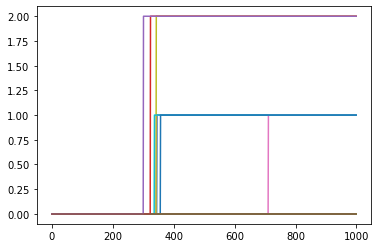

In [18]:
PI_array = q_learning(N_epoch=1000, N_Iter=100, learning_rate=0.01, exploration=0.5, trace_flag=True)
print(PI_array)
plt.plot(PI_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 1 ... 2 2 0]
 [1 0 1 ... 2 2 0]
 [1 0 1 ... 2 2 0]]


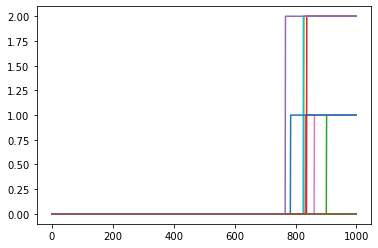

In [19]:
PI_array = q_learning(N_epoch=1000, N_Iter=100, learning_rate=0.01, exploration=0.6, trace_flag=True)
print(PI_array)
plt.plot(PI_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 2 1 ... 2 2 0]
 [1 2 1 ... 2 2 0]
 [1 2 1 ... 2 2 0]]


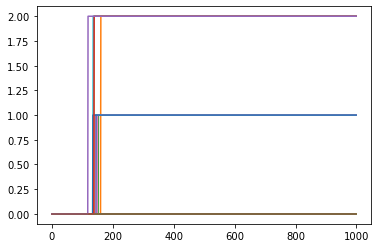

In [20]:
PI_array = q_learning(N_epoch=1000, N_Iter=100, learning_rate=0.01, exploration=0.8, trace_flag=True)
print(PI_array)
plt.plot(PI_array)